Загрузка данных

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

testDF = pd.read_csv('credit_test.csv')
trainDF = pd.read_csv('credit_train.csv')

print(trainDF.shape)
print(trainDF.nunique())

(100000, 19)
Loan ID                         81999
Customer ID                     81999
Loan Status                         2
Current Loan Amount             22004
Term                                2
Credit Score                      324
Annual Income                   36174
Years in current job               11
Home Ownership                      4
Purpose                            16
Monthly Debt                    65765
Years of Credit History           506
Months since last delinquent      116
Number of Open Accounts            51
Number of Credit Problems          14
Current Credit Balance          32730
Maximum Open Credit             44596
Bankruptcies                        8
Tax Liens                          12
dtype: int64


In [98]:
print("Общая информация о пропусках:")
print(trainDF.isnull().sum())  # Количество NaN в каждом столбце
trainDF = trainDF.fillna(0) # Заполнение пропусков нулями

Общая информация о пропусках:
Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    19154
Annual Income                   19154
Years in current job             4222
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    53141
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 2
Bankruptcies                      204
Tax Liens                          10
dtype: int64


Удаление дупликатов

In [99]:
trainDF = trainDF.drop_duplicates(subset=['Loan ID'])
trainDF.nunique()

Loan ID                         81999
Customer ID                     81999
Loan Status                         2
Current Loan Amount             21821
Term                                2
Credit Score                      325
Annual Income                   35523
Years in current job               12
Home Ownership                      4
Purpose                            16
Monthly Debt                    65765
Years of Credit History           506
Months since last delinquent      116
Number of Open Accounts            51
Number of Credit Problems          14
Current Credit Balance          32730
Maximum Open Credit             44596
Bankruptcies                        8
Tax Liens                          12
dtype: int64

Анализ на выбросы

Original shape: (81999, 19), Cleaned shape: (64123, 19)


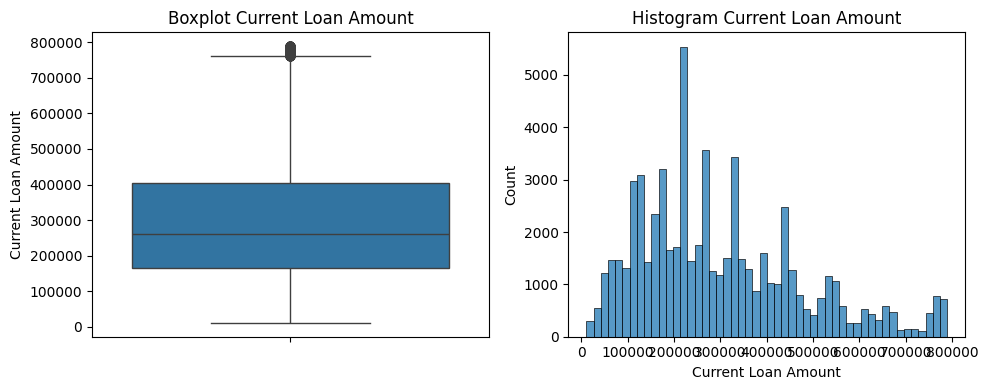

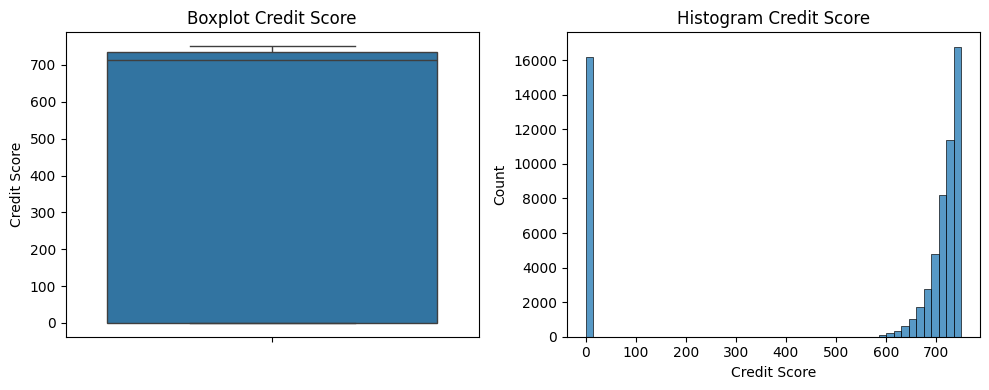

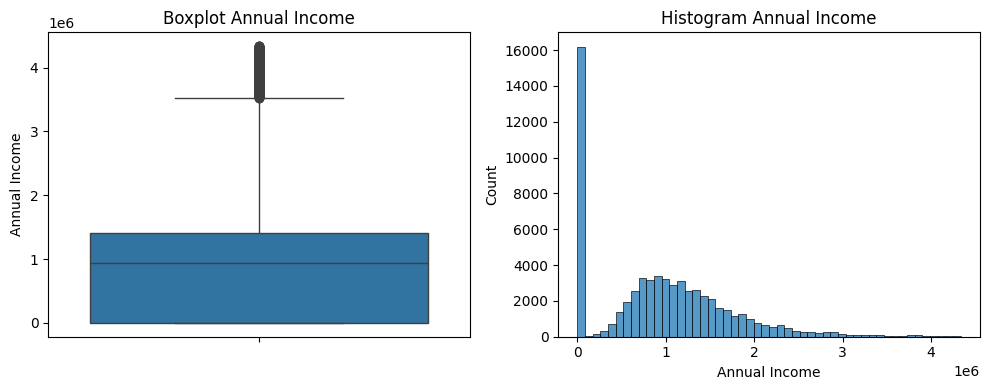

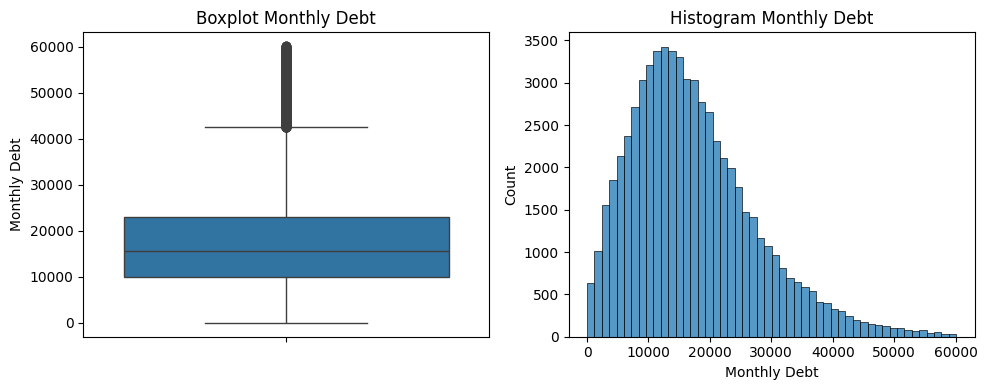

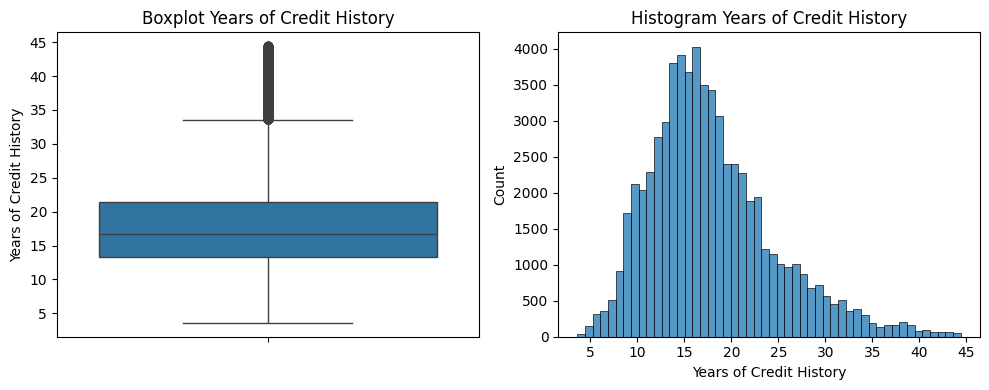

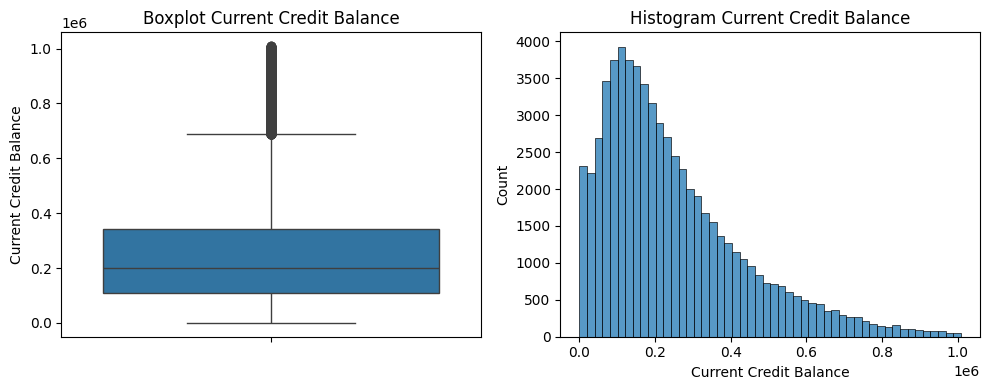

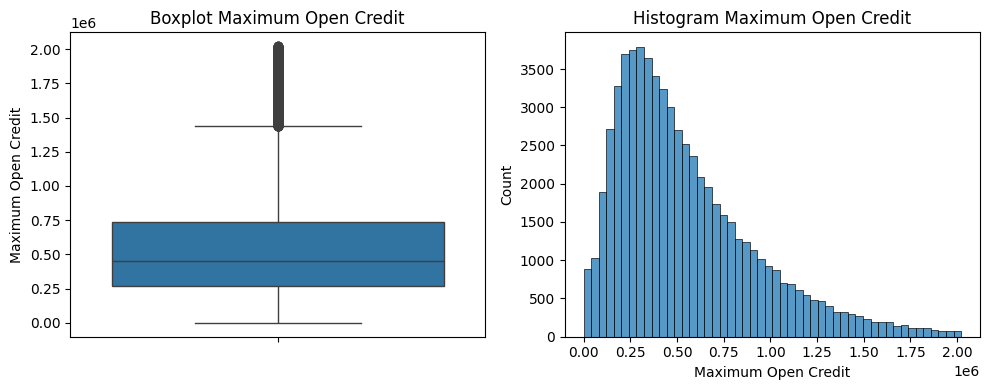

In [100]:
def show_boxplot_histogram(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [x for x in numeric_columns if df[x].nunique() > 100]
    for col in numeric_columns:
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot {col}')
        
        plt.subplot(1, 2, 2)
        sns.histplot(df[col], bins=50)
        plt.title(f'Histogram {col}')
        
        plt.tight_layout()
        plt.show()

def remove_outliers_iqr(df, columns): #Возможно все еще жестковато
    df_clean = df.copy()
    
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.10)
            Q3 = df_clean[col].quantile(0.80)
            IQR = Q3 - Q1
            factor = 1.7
            
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            
            mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
            df_clean = df_clean[mask]
    
    return df_clean

numeric_columns = trainDF.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [x for x in numeric_columns if trainDF[x].nunique() > 100]
trainDF_clean = remove_outliers_iqr(trainDF, numeric_columns)
print(f'Original shape: {trainDF.shape}, Cleaned shape: {trainDF_clean.shape}')
show_boxplot_histogram(trainDF_clean)
trainDF = trainDF_clean

Кодирование признаков

In [101]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def term_encoding():
    trainDF['Term'] = (trainDF['Term'] == 'Long Term').astype(int)
term_encoding()

def years_in_current_job_encoding():
    years_mapping = {
        '< 1 year': 0,
        '0': 0.5,  # между "< 1 year" и "1 year"
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10  # или можно 11 для четкого разделения
    }
    trainDF['Years in current job'] = trainDF['Years in current job'].map(years_mapping)
years_in_current_job_encoding()


CATEGORICAL_FEATURES = [
    'Home Ownership',      # 3 категории: Own, Home Mortgage, Rent
    'Purpose'             # много категорий: Debt Consolidation, Home Improvement и др.
]

NUMERICAL_FEATURES = [
    'Term',                      # уже закодирован как 0/1
    'Current Loan Amount',       # размер кредита
    'Credit Score',              # кредитный рейтинг (0-800)
    'Annual Income',             # годовой доход
    'Monthly Debt',              # ежемесячный долг
    'Years of Credit History',   # лет кредитной истории
    'Years in current job',      # лет на текущей работе
    'Months since last delinquent',  # месяцев с последнего нарушения
    'Number of Open Accounts',   # открытые счета
    'Number of Credit Problems', # кредитные проблемы
    'Current Credit Balance',    # текущий долг
    'Maximum Open Credit',       # максимальный кредитный лимит
    'Bankruptcies',             # банкротства
    'Tax Liens'                 # налоговые нарушения
]

# ID признаки - исключаем из модели
ID_FEATURES = ['Loan ID', 'Customer ID']

# Целевая переменная
TARGET = 'Loan Status'

if trainDF[TARGET].dtype == 'object':
    trainDF[TARGET] = trainDF[TARGET].map({'Fully Paid': 0, 'Charged Off': 1})

X = trainDF.drop([TARGET] + ID_FEATURES, axis=1, errors='ignore')
y = trainDF[TARGET]

# 3. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [102]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

preprocessor = ColumnTransformer(
    transformers=[
        # Категориальные признаки: OneHot Encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(
                drop='first',            # избегаем дамми-ловушки
                handle_unknown='ignore', # для новых категорий в тесте
                sparse_output=False      # для удобства работы
            ))
        ]), CATEGORICAL_FEATURES),
        
        # Числовые признаки без сильных выбросов: StandardScaler
        ('num_standard', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), NUMERICAL_FEATURES),
    ],
    remainder='drop'  # остальные признаки не используем
)

# 5. Полный пайплайн с моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',  # важно для несбалансированных данных
        random_state=42,
        n_jobs=-1
    ))
])

# 6. Обучение модели
print("\nОбучение модели...")
pipeline.fit(X_train, y_train)

# 7. Оценка
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")



Обучение модели...
Train accuracy: 0.6728
Test accuracy: 0.6272
